In [9]:
from elasticsearch import Elasticsearch

client = Elasticsearch(hosts='http://localhost:9200')

patent_text_field = "名称"
patent_embedding_field = "名称_embedding"
patent_index = "f28fbc38-e0cf-44ff-9c98-0ca49f2a2c6f"
patent_query_filter = "发明"  # field: 类型

paper_text_field = "标题"
paper_embedding_field = "标题_embedding"
paper_index = "05ce8f39-4201-48f1-a87a-616c7216470b"


In [10]:
# 取的发明专利标题和知网论文数据各1000条的embedding
# 存储到pandas df中，目标数据结构为:类型，文本，嵌入向量
# 现在还需要再查询中筛选is_embedded字段为true
# 此外相关字段和信息有更新

import pandas as pd

# 构建专利查询，包括is_embedded为true的条件
patent_query = {
    "size": 1000,
    "query": {
        "bool": {
            "must": [
                {"match": {"类型": patent_query_filter}},
                {"term": {"is_embedded": True}}
            ]
        }
    },
    "_source": [patent_text_field, patent_embedding_field]
}

# 执行专利查询
patent_response = client.search(index=patent_index, body=patent_query)

# 构建论文查询，包括is_embedded为true的条件
paper_query = {
    "size": 1000,
    "query": {
        "term": {"is_embedded": True}
    },
    "_source": [paper_text_field, paper_embedding_field]
}

# 执行论文查询
paper_response = client.search(index=paper_index, body=paper_query)

# 创建空DataFrame
data = pd.DataFrame(columns=["类型", "文本", "嵌入向量"])

# 处理专利数据
for hit in patent_response['hits']['hits']:
    data = pd.concat([data, pd.DataFrame([{
        "类型": "发明专利",
        "文本": hit['_source'].get(patent_text_field, ""),
        "嵌入向量": hit['_source'].get(patent_embedding_field, [])
    }])], ignore_index=True)

# 处理论文数据
for hit in paper_response['hits']['hits']:
    data = pd.concat([data, pd.DataFrame([{
        "类型": "知网论文",
        "文本": hit['_source'].get(paper_text_field, ""),
        "嵌入向量": hit['_source'].get(paper_embedding_field, [])
    }])], ignore_index=True)

# 打印DataFrame的前几行以确认数据
data.head()

,类型,文本,嵌入向量
0,发明专利,一种真双极柔性直流输电系统的站级控制方法,"[0.0012713153846561909, 0.03751654177904129, -..."
1,发明专利,一种改进型的信箱装置,"[0.01283657643944025, 0.033058565109968185, -0..."
2,发明专利,一种用于净化被污染水体的新型明矾处理装置,"[0.024517972022294998, 0.031447507441043854, -..."
3,发明专利,一种改进型信息技术设备,"[0.025523880496621132, 0.037812866270542145, -..."
4,发明专利,一种面罩热敷装置,"[0.05266658216714859, 0.039630964398384094, -0..."


In [14]:
# 查询所有prompt的embedding，分别命名为 学术abcd 和 应用abcd

# 查询文本text的embedding的方法：
# text_list: list[str] = ["",""]
# import requests
# res = requests.post(
#     "http://localhost:8002/embedding/text-list",
#     json={
#         "ls": text_list
#     }
# )
# embeddings: list[list[float]] = res.json()

import requests

# 学术价值的prompt列表
academic_prompts = [
    "学术价值高",
    "高度的创新性和前瞻性，学术界有影响，贡献于科学理论，推动了不同领域的融合",
    "系统的较专门的学问、观点、主张、学风和本领等，探究性的活动",
    "创造高深知识的，具有专业性、风险性、曲折性、连续性和未知性"
]

# 应用价值的prompt列表
application_prompts = [
    "应用价值高",
    "有明显的市场应用潜力，行业内有影响，贡献于实践领域，提供了关键技术或方法",
    "研究成果转化和产业化，与经济发展有联系，参与政府或社会的服务",
    "结合实际需求，产出可以解决并满足社会经济发展需要的科技成果"
]

# 将两组prompts合并为一个请求
all_prompts = academic_prompts + application_prompts

# 发送请求以获取嵌入向量
response = requests.post(
    "http://localhost:8002/embedding/text-list",
    json={"ls": all_prompts}
)

# 获取返回的嵌入向量
embeddings = response.json()

print(len(embeddings), len(embeddings[0]))

8 1024


In [16]:
# 将各个prompt的嵌入 和所有的文本的嵌入 都算一遍余弦相似度，
# 将相似度的值存储到对应文本嵌入的 prompt 名字列中。数据结构为
# 类型，文本，嵌入向量，学术a，学术b，....,应用c，应用d

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 假设已经有的DataFrame和Prompt嵌入向量
# data是先前提到的DataFrame
# embeddings是prompt嵌入向量列表

# 计算余弦相似度的函数
def calculate_cosine_similarity(v1, v2):
    return cosine_similarity([v1], [v2])[0][0]

# 假设你已经有了prompts和它们的名称
prompt_names = ["学术a", "学术b", "学术c", "学术d", "应用a", "应用b", "应用c", "应用d"]

# 为每个prompt添加列初始化
for name in prompt_names:
    data[name] = np.nan

# 遍历DataFrame的每一行
for index, row in data.iterrows():
    text_embedding = row['嵌入向量']
    # 对每个prompt计算余弦相似度
    for prompt_name, prompt_embedding in zip(prompt_names, embeddings):
        # 计算余弦相似度并存储
        similarity = calculate_cosine_similarity(text_embedding, prompt_embedding)
        data.at[index, prompt_name] = similarity

# 显示更新后的DataFrame
data.head()


,类型,文本,嵌入向量,学术a,学术b,学术c,学术d,应用a,应用b,应用c,应用d
0,发明专利,一种真双极柔性直流输电系统的站级控制方法,"[0.0012713153846561909, 0.03751654177904129, -...",0.822549,0.828991,0.824640,0.821711,0.837512,0.840414,0.828865,0.831340
1,发明专利,一种改进型的信箱装置,"[0.01283657643944025, 0.033058565109968185, -0...",0.853548,0.845606,0.835871,0.833594,0.882441,0.855930,0.837303,0.833158
2,发明专利,一种用于净化被污染水体的新型明矾处理装置,"[0.024517972022294998, 0.031447507441043854, -...",0.848964,0.857252,0.831287,0.841843,0.866750,0.862498,0.860411,0.854973
3,发明专利,一种改进型信息技术设备,"[0.025523880496621132, 0.037812866270542145, -...",0.874142,0.859079,0.857163,0.853041,0.901702,0.876899,0.858260,0.858733
4,发明专利,一种面罩热敷装置,"[0.05266658216714859, 0.039630964398384094, -0...",0.842269,0.831545,0.825456,0.826475,0.869116,0.843878,0.840070,0.836774


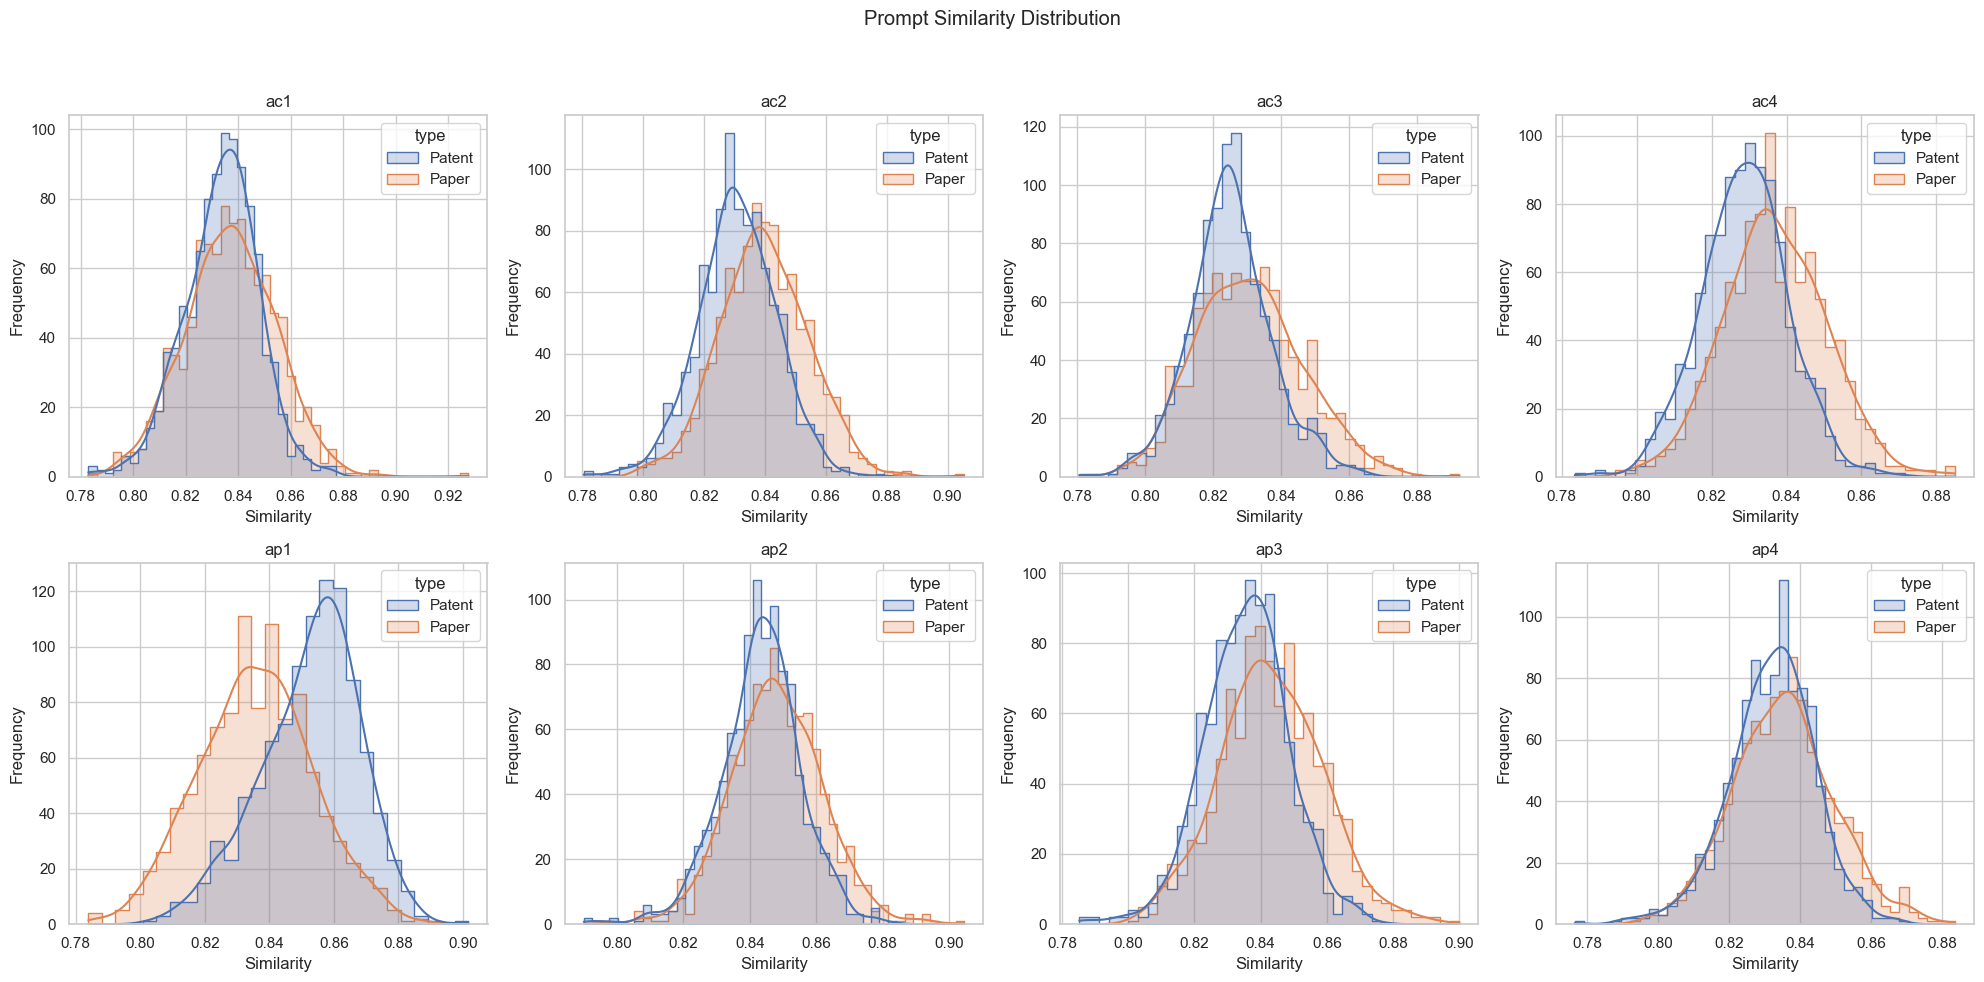

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 分析各个prompt的区分度，即一个prompt下，
# 不同类型文本的相似度差距/分布的差距
# 先绘制分布的图像，不同的文本类型的用不同的颜色
# 使用seaborn

# sns.set(style="whitegrid")
# Function `set` is deprecated in favor of `set_theme`
# 不要在图像中绘制中文，学术和应用分别用ac和ap代替

# **数据列名称**：确保你的`data` DataFrame已经包含了修改后的prompt名称作为列名，
# 如果原来的列名是中文，需要进行相应的替换。
# 请你完成之一部分替换

# 假设data是原始的DataFrame
# 替换列名
data = data.rename(columns={
    '学术a': 'ac1',
    '学术b': 'ac2',
    '学术c': 'ac3',
    '学术d': 'ac4',
    '应用a': 'ap1',
    '应用b': 'ap2',
    '应用c': 'ap3',
    '应用d': 'ap4',
    '类型': 'type'
})

# 更新风格设置
sns.set_theme(style="whitegrid")

# 创建一个图像，其中包含多个子图（每个prompt一个子图）
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 调整子图布局和大小
fig.suptitle('Prompt Similarity Distribution')

# 新的prompt名称
prompt_names = ["ac1", "ac2", "ac3", "ac4", "ap1", "ap2", "ap3", "ap4"]
cate_map = {
    "发明专利": "Patent",
    "知网论文": "Paper"
}
data["type"] = data['type'].map(lambda x: cate_map[x] if x in cate_map else x)

# 遍历所有prompts并绘制每个prompt的分布
for i, prompt_name in enumerate(prompt_names):
    ax = axes[i // 4, i % 4]  # 定位到具体的子图
    sns.histplot(data=data, x=prompt_name, hue="type", kde=True, element="step", ax=ax)
    ax.set_title(prompt_name)
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整整体布局，避免标题被覆盖
plt.show()


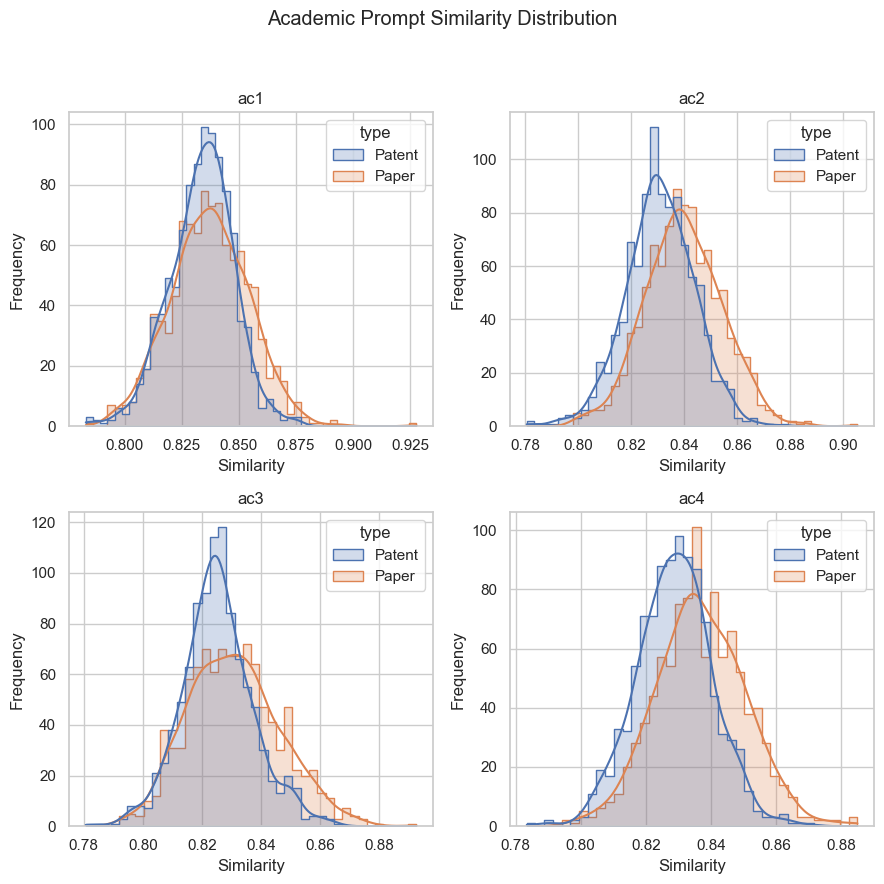

In [27]:
# 我对值和列名做了进一步的替换
# 现在请单独画ac的4种prompt
# 布局要求为2*2

# 创建一个图像，包含四个子图（每个ac prompt一个子图）
fig, axes = plt.subplots(2, 2, figsize=(9, 9))  # 2x2布局
fig.suptitle('Academic Prompt Similarity Distribution')

# 学术prompt的名称列表
academic_prompts = ["ac1", "ac2", "ac3", "ac4"]

# 遍历所有学术prompts并绘制每个prompt的分布
for i, prompt_name in enumerate(academic_prompts):
    ax = axes[i // 2, i % 2]  # 定位到具体的子图
    sns.histplot(data=data, x=prompt_name, hue="type", kde=True, element="step", ax=ax)
    ax.set_title(prompt_name)
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整整体布局，避免标题被覆盖
plt.show()


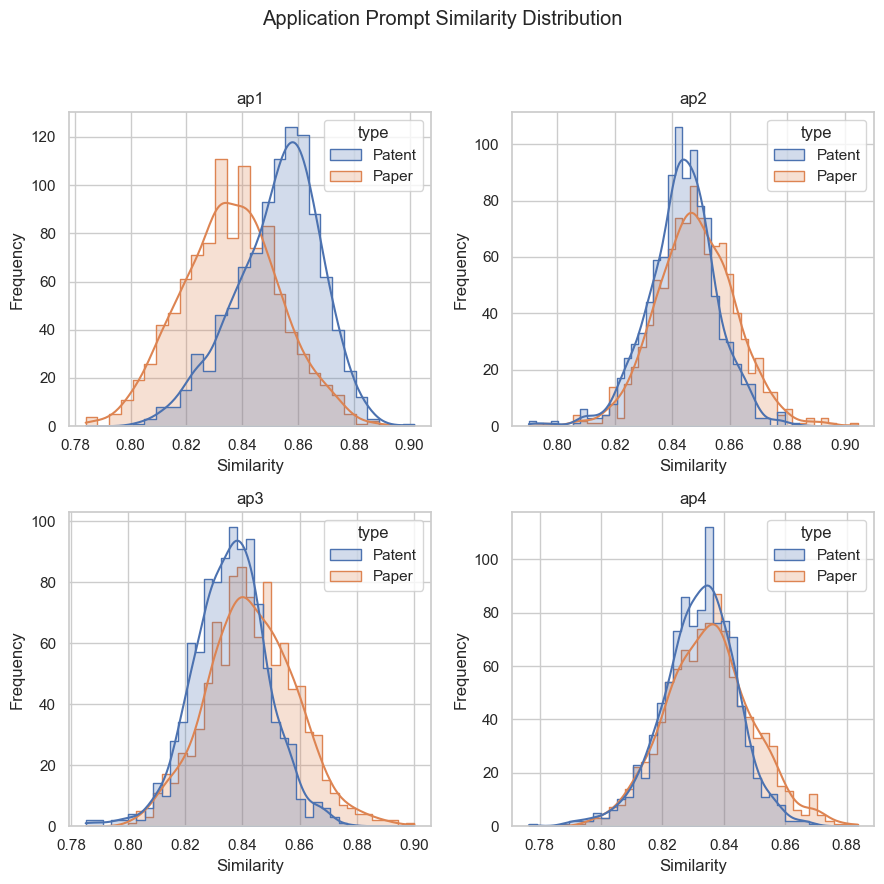

In [28]:
# 我对值和列名做了进一步的替换
# 现在请单独画ac的4种prompt
# 布局要求为2*2

# 创建一个图像，包含四个子图（每个ac prompt一个子图）
fig, axes = plt.subplots(2, 2, figsize=(9, 9))  # 2x2布局
fig.suptitle('Application Prompt Similarity Distribution')

# 应用prompt的名称列表
application_prompts = ["ap1", "ap2", "ap3", "ap4"]

# 遍历所有学术prompts并绘制每个prompt的分布
for i, prompt_name in enumerate(application_prompts):
    ax = axes[i // 2, i % 2]  # 定位到具体的子图
    sns.histplot(data=data, x=prompt_name, hue="type", kde=True, element="step", ax=ax)
    ax.set_title(prompt_name)
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整整体布局，避免标题被覆盖
plt.show()


In [33]:
# 现在继续分析prompts之间的性能
# 刚才从图像上直观地观察了分布差异
# 现在请你计算一些指标，通过数值来检验差异大小

# 提取所需的prompts
import pandas as pd
prompts = ["ac1", "ac2", "ac3", "ac4", "ap1", "ap2", "ap3", "ap4"]

# 初始化一个空的DataFrame来存储结果
stats_data = []

# 遍历每个prompt，分组计算统计指标
for prompt in prompts:
    for t in data['type'].unique():
        subset = data[data['type'] == t][prompt]
        mean_val = subset.mean()
        std_val = subset.std()
        median_val = subset.median()
        iqr_val = subset.quantile(0.75) - subset.quantile(0.25)
        
        # 将结果添加到stats_data
        stats_data.append({
            'Prompt': prompt,
            'Type': t,
            'Mean': mean_val,
            'STD': std_val,
            'Median': median_val,
            'IQR': iqr_val
        })

# 显示统计结果
stats_data = pd.DataFrame(stats_data)
stats_data



,Prompt,Type,Mean,STD,Median,IQR
0,ac1,Patent,0.833680,0.014064,0.834719,0.018016
1,ac1,Paper,0.837128,0.017258,0.837303,0.023070
2,ac2,Patent,0.830884,0.012880,0.830624,0.016497
3,ac2,Paper,0.839689,0.014559,0.839316,0.019490
4,ac3,Patent,0.825214,0.012066,0.824914,0.013951
5,ac3,Paper,0.830740,0.015558,0.830242,0.021105
6,ac4,Patent,0.828808,0.011665,0.828962,0.015389
7,ac4,Paper,0.836834,0.013760,0.836217,0.018476
8,ap1,Patent,0.852571,0.015357,0.854531,0.020255
9,ap1,Paper,0.835828,0.017510,0.835317,0.024052


In [34]:

import scipy.stats as stats

# 提取所需的prompts
prompts = ["ac1", "ac2", "ac3", "ac4", "ap1", "ap2", "ap3", "ap4"]

# 初始化一个空的DataFrame来存储假设检验结果
test_results = pd.DataFrame(columns=['Prompt', 'Test', 'p-value', 'Significant'])

# 遍历每个prompt，对不同类型文本进行假设检验
for prompt in prompts:
    # 提取两种类型文本的数据
    data_patent = data[data['type'] == 'Patent'][prompt].dropna()
    data_paper = data[data['type'] == 'Paper'][prompt].dropna()
    
    # 检查正态性
    normal_patent = stats.shapiro(data_patent).pvalue > 0.05
    normal_paper = stats.shapiro(data_paper).pvalue > 0.05
    
    # 根据数据的正态性选择检验方法
    if normal_patent and normal_paper:
        # 使用独立样本t检验
        test_stat, p_value = stats.ttest_ind(data_patent, data_paper)
        test_name = 'Independent T-test'
    else:
        # 使用Mann-Whitney U检验
        test_stat, p_value = stats.mannwhitneyu(data_patent, data_paper)
        test_name = 'Mann-Whitney U'
    
    # 判断统计显著性
    significant = 'Yes' if p_value < 0.05 else 'No'
    
    # 存储检验结果
    new_result = pd.DataFrame({
        'Prompt': [prompt],
        'Test': [test_name],
        'p-value': [p_value],
        'Significant': [significant]
    })
    test_results = pd.concat([test_results, new_result], ignore_index=True)

# 显示检验结果
test_results


C:\Users\realj\AppData\Local\Temp\ipykernel_15748\4004089620.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_results = pd.concat([test_results, new_result], ignore_index=True)


,Prompt,Test,p-value,Significant
0,ac1,Mann-Whitney U,1.006545e-05,Yes
1,ac2,Mann-Whitney U,2.017022e-41,Yes
2,ac3,Mann-Whitney U,8.172854e-16,Yes
3,ac4,Independent T-test,6.067605e-43,Yes
4,ap1,Mann-Whitney U,6.480218e-95,Yes
5,ap2,Mann-Whitney U,2.530475e-14,Yes
6,ap3,Mann-Whitney U,9.212851e-28,Yes
7,ap4,Mann-Whitney U,3.071612e-06,Yes


In [35]:
# ac4 ap1

data["ac4"].describe()


count    2000.000000
mean        0.832821
std         0.013369
min         0.783460
25%         0.824148
50%         0.832441
75%         0.841137
max         0.884964
Name: ac4, dtype: float64

In [36]:
data["ap1"].describe()


count    2000.000000
mean        0.844200
std         0.018472
min         0.783888
25%         0.831561
50%         0.845252
75%         0.858098
max         0.901702
Name: ap1, dtype: float64